# Introduction

Welcome to the Automated Data Science hands-on Colab notebook for AutoML School 2024!

In this session, you’ll learn how to effectively use the Quick-Tune-Tool. We’ll guide you through:

* Installing `QuickTuneTool`,
* Exploring its key components,
* Utilizing meta-trained predictors to kickstart your runs,
* Loading and testing a fine-tuned model for inference.

❗ Ensure that you are connected to a runtime with a GPU. Running on a CPU is not practicable.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/automl/QTT/blob/main/notebooks/automl_school_demo.ipynb")

# 🕮 Installation

The following cell installs the QTT package.

Restart your runtime and rerun the cell, if Colab asks for it.

In [ ]:
!pip install git+https://github.com/automl/QTT

# 🕮 Necessary Imports for the Notebook

The examples in this notebook require the following imports.
Make sure to run this cell before any other cell.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms as tf
from qtt import QuickOptimizer, QuickTuner, QuickCVCLSTuner
from qtt.predictors import PerfPredictor, CostPredictor
from qtt.pretrained import load_pretrained_optimizer
from qtt.finetune.cv.classification import extract_task_info_metafeat, finetune_script
from ConfigSpace import (
    Categorical,
    ConfigurationSpace,
    Constant,
    EqualsCondition,
    OrConjunction,
    OrdinalHyperparameter,
)

# 🔽 Download the Meta-Dataset

We begin by downloading the Meta-Dataset, our source to meta-train predictive models. The Meta-Dataset comprises evaluated pipelines on different datasets, including hyperparameter configurations and their associated learning curves. These learning curves capture the performance of a pipeline across various fidelities, such as validation accuracy over the number of epochs.

The Meta-Dataset is available in three versions: `micro`, `mini`, and `extended`. For our experiments, we will utilize the `mini` version.

In [ ]:
# @title download
%%capture
!wget https://nextcloud.tf.uni-freiburg.de/index.php/s/fQmPmB84EmwxddJ/download/mtlbm.zip
!unzip mtlbm.zip -d mtlbm

Now, let's have a look at the Meta-Dataset.

In [ ]:
# @title load the data

config = pd.read_csv("mtlbm/mini/config.csv", index_col=0)
cost = pd.read_csv("mtlbm/mini/cost.csv", index_col=0)
meta = pd.read_csv("mtlbm/mini/meta.csv", index_col=0)
curve = pd.read_csv("mtlbm/mini/curve.csv", index_col=0)
config.head()

,amp,batch_size,bss_reg,clip_grad,cotuning_reg,cutmix,decay_epochs,decay_rate,delta_reg,drop,...,sched,smoothing,sp_reg,stoch_norm,warmup_epochs,warmup_lr,weight_decay,opt_betas,data_augmentation,auto_augment
74417154365539438,False,128,0.100,1.0,2.0,0.50,20.0,0.1,0.0100,0.4,...,multistep,0.00,0.0000,False,5,0.0,0.01000,"(0.9, 0.99)",none,NaN
8461644391739478,False,4,0.001,NaN,4.0,4.00,0.0,0.1,0.0001,0.2,...,cosine,0.00,0.1000,False,10,0.0,0.10000,NaN,trivial_augment,NaN
28759971764404954,False,64,0.010,1.0,0.0,1.00,0.0,0.1,0.0100,0.4,...,plateau,0.10,0.0001,True,10,0.0,0.00010,NaN,none,NaN
13521192914230212,False,32,0.000,10.0,0.5,4.00,20.0,0.1,0.1000,0.4,...,multistep,0.00,0.0001,False,0,0.0,0.00001,"(0.9, 0.999)",trivial_augment,NaN
63905311029357793,True,2,0.100,1.0,4.0,0.25,20.0,0.5,0.0100,0.4,...,multistep,0.05,0.1000,True,10,0.0,0.00000,"(0.0, 0.99)",trivial_augment,NaN


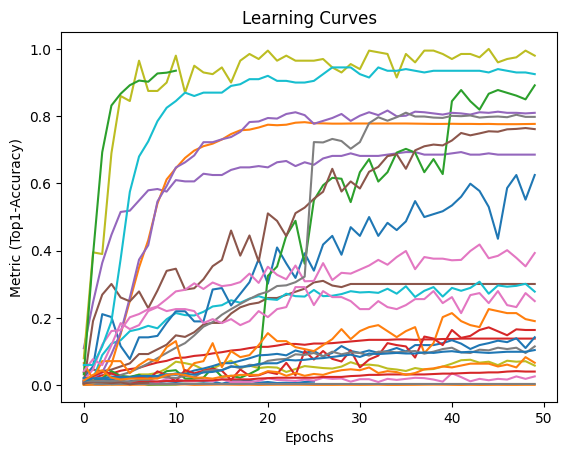

In [ ]:
# @title Plot a few learning curves

subset = curve.sample(32)

for index, row in subset.iterrows():
    plt.plot(row.values)

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Metric (Top1-Accuracy)')
plt.title('Learning Curves')

# Show plot
plt.show()

# How-To

## Predictors

Performance-Predictor:
- probabilistic performance estimator
- implemented as a deep-kernel Gaussian Process regressor

### Meta-Train Predictors

We use the learning curves of the meta-dataset to meta-train the Predictors

In [ ]:
X = pd.concat([config, meta], axis=1)
y = curve.values

perf_predictor = PerfPredictor().fit(X, y)

y = cost.values
cost_predictor = CostPredictor().fit(X, y)

## Predictions on unseen data.

We use the learning curves from the micro subset by performing the following steps:

* Randomly select pipelines.
* Sample a fidelity level.
* Input the samples into the predictor.



In [ ]:
num_samples = 10
max_fidelity = 50

micro_config = pd.read_csv("mtlbm/micro/config.csv", index_col=0)
micro_cost = pd.read_csv("mtlbm/micro/cost.csv", index_col=0)
micro_meta = pd.read_csv("mtlbm/micro/meta.csv", index_col=0)
micro_curve = pd.read_csv("mtlbm/micro/curve.csv", index_col=0)

micro_X = pd.concat([micro_config, micro_meta], axis=1)
test_X = micro_X.sample(num_samples)
_y = micro_curve.loc[test_X.index].values

index = np.random.randint(max_fidelity, size=num_samples)
index = np.minimum(index, max_fidelity - np.isnan(_y).sum(axis=1))
val_y = _y[np.arange(num_samples), index]
test_y = np.zeros_like(_y)
for n, m in enumerate(index):
  test_y[n][:m] = _y[n][:m]

pred_score, _ = perf_predictor.predict(test_X, test_y)

for n, row in enumerate(test_y):
    vals = row[row.nonzero()]
    plt.plot(vals)
    plt.scatter(index[n], pred_score[n])

# Add labels and legend
plt.xlabel('Fidelity (Epochs)')
plt.ylabel('Metric (Top1-Accuracy)')
plt.title('Learning Curve Predictions')
plt.show()

## 🔥 Downloading a Vision Dataset

To demonstrate the use of QTT, we'll work with the Imagenette dataset. Given the constraints of Colab's hardware, we'll use a small subset of the images:

- **Training Set**: 40 samples per class
- **Validation Set**: 10 samples per class
- **Test Set**: 5 samples per class

This setup will allow us to showcase the capabilities of QTT while working within Colab’s limitations.


In [ ]:
# @title download + process
%%capture
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xzvf imagenette2-320.tgz

import os
import shutil


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def copy_files(src_dir, dest_dir, start_idx, end_idx):
    files = sorted(os.listdir(src_dir))
    total_files = len(files)
    if start_idx >= 0 and end_idx < total_files:
        for i in range(start_idx, end_idx + 1):
            shutil.copy(os.path.join(src_dir, files[i]), dest_dir)


# Create necessary directories
create_dir("dataset/train")
create_dir("dataset/val")
create_dir("dataset/test")

# Process training set
train_dir = "imagenette2-320/train"
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        create_dir(os.path.join("dataset/train", class_name))
        copy_files(class_dir, os.path.join("dataset/train", class_name), 0, 39)

# Process validation set
val_dir = "imagenette2-320/val"
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    if os.path.isdir(class_dir):
        create_dir(os.path.join("dataset/val", class_name))
        create_dir(os.path.join("dataset/test", class_name))

        total_files = len(os.listdir(class_dir))

        # Copy first 20 images to validation set
        copy_files(class_dir, os.path.join("dataset/val", class_name), 0, 19)

        # Copy last 5 images to test set
        copy_files(
            class_dir,
            os.path.join("dataset/test", class_name),
            total_files - 5,
            total_files - 1,
        )

### Downloading Custom Datasets

If you want to try out QTT yourself, you need to provide the data in Pytorch's ImageFolder format:


In [ ]:
# @title format hint

root/
├── train/
│   ├── class_1/
│   │   ├── img_1.jpg
│   │   ├── img_2.jpg
│   │   └── ...
│   ├── class_2/
│   │   ├── img_1.jpg
│   │   ├── img_2.jpg
│   │   └── ...
│   │ ...
│
├── val/
│   ├── class_1/
│   │   ├── img_1.jpg
│   │   ├── img_2.jpg
│   │   └── ...
│   ├── class_2/
│   │   ├── img_1.jpg
│   │   ├── img_2.jpg
│   │   └── ...
│   │ ...
│
└── test/
    ├── class_1/
    │   ├── img_1.jpg
    │   ├── img_2.jpg
    │   └── ...
    ├── class_2/
    │   ├── img_1.jpg
    │   ├── img_2.jpg
    │   └── ...
    |...


## Define Search Space

To accommodate Colab's hardware limitations, we will make some adjustments to the Search Space. Specifically, we will:

- Limit the models to a maximum of 30 million parameters
- Reduce the maximum batch size to 64





In [ ]:
cs = ConfigurationSpace("cv-classification")
freeze = OrdinalHyperparameter("pct_to_freeze", [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ld = OrdinalHyperparameter("layer_decay", [0.0, 0.65, 0.75])
lp = OrdinalHyperparameter("linear_probing", [False, True])
sn = OrdinalHyperparameter("stoch_norm", [False, True])
sr = OrdinalHyperparameter("sp_reg", [0.0, 0.0001, 0.001, 0.01, 0.1])
d_reg = OrdinalHyperparameter("delta_reg", [0.0, 0.0001, 0.001, 0.01, 0.1])
bss = OrdinalHyperparameter("bss_reg", [0.0, 0.0001, 0.001, 0.01, 0.1])
cot = OrdinalHyperparameter("cotuning_reg", [0.0])
mix = OrdinalHyperparameter("mixup", [0.0, 0.2, 0.4, 1.0, 2.0, 4.0, 8.0])
mix_p = OrdinalHyperparameter("mixup_prob", [0.0, 0.25, 0.5, 0.75, 1.0])
cut = OrdinalHyperparameter("cutmix", [0.0, 0.1, 0.25, 0.5, 1.0, 2.0, 4.0])
drop = OrdinalHyperparameter("drop", [0.0, 0.1, 0.2, 0.3, 0.4])
smooth = OrdinalHyperparameter("smoothing", [0.0, 0.05, 0.1])
clip = OrdinalHyperparameter("clip_grad", [0, 1, 10])
amp = OrdinalHyperparameter("amp", [False, True])
opt = Categorical("opt", ["sgd", "momentum", "adam", "adamw", "adamp"])
betas = Categorical("opt_betas", ["(0.9, 0.999)", "(0.0, 0.99)", "(0.9, 0.99)", "(0.0, 0.999)"])
lr = OrdinalHyperparameter("lr", [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01])
w_ep = OrdinalHyperparameter("warmup_epochs", [0, 5, 10])
w_lr = OrdinalHyperparameter("warmup_lr", [0.0, 1e-05, 1e-06])
wd = OrdinalHyperparameter("weight_decay", [0, 1e-05, 0.0001, 0.001, 0.01, 0.1])
bs = OrdinalHyperparameter("batch_size", [16, 32, 64])
mom = OrdinalHyperparameter("momentum", [0.0, 0.8, 0.9, 0.95, 0.99])
sched = Categorical("sched", ["cosine", "step", "multistep", "plateau"])
pe = OrdinalHyperparameter("patience_epochs", [2, 5, 10])
dr = OrdinalHyperparameter("decay_rate", [0.1, 0.5])
de = OrdinalHyperparameter("decay_epochs", [10, 20])
da = Categorical("data_augmentation", ["auto_augment", "random_augment", "trivial_augment", "none"])
aa = Categorical("auto_augment", ["v0", "original"])
ra_nops = OrdinalHyperparameter("ra_num_ops", [2, 3])
ra_mag = OrdinalHyperparameter("ra_magnitude", [9, 17])
cond_1 = EqualsCondition(pe, sched, "plateau")
cond_2 = OrConjunction(EqualsCondition(dr, sched, "step"), EqualsCondition(dr, sched, "multistep"))
cond_3 = OrConjunction(EqualsCondition(de, sched, "step"), EqualsCondition(de, sched, "multistep"))
cond_4 = EqualsCondition(mom, opt, "momentum")
cond_5 = OrConjunction(EqualsCondition(betas, opt, "adam"), EqualsCondition(betas, opt, "adamw"), EqualsCondition(betas, opt, "adamp"))
cond_6 = EqualsCondition(ra_nops, da, "random_augment")
cond_7 = EqualsCondition(ra_mag, da, "random_augment")
cond_8 = EqualsCondition(aa, da, "auto_augment")
cs.add(mix, mix_p, cut, drop, smooth, clip, freeze, ld, lp, sn, sr, d_reg, bss, cot, amp, opt, betas, lr, w_ep, w_lr, wd, bs, mom, sched, pe, dr, de, da, aa, ra_nops, ra_mag, cond_1, cond_2, cond_3, cond_4, cond_5, cond_6, cond_7, cond_8)
model = Categorical("model", ["deit3_small_patch16_384_in21ft1k", "dla46x_c", "edgenext_small", "edgenext_x_small", "edgenext_xx_small", "mobilevit_xs", "mobilevit_xxs", "mobilevitv2_075", "tf_efficientnet_b4_ns", "volo_d1_384", "xcit_nano_12_p8_384_dist", "xcit_small_12_p8_384_dist", "xcit_tiny_12_p8_384_dist", "xcit_tiny_24_p8_384_dist"])
cs.add(model)

## Create Optimizer

In [ ]:
optimizer = QuickOptimizer(
    cs,
    max_fidelity=50,                # number of steps, e.g. epochs, must match the length of learning curves passed during fitting
    perf_predictor=perf_predictor,
    cost_predictor=cost_predictor,
    cost_aware=True,
    cost_factor=1.0,                # balances the importance of the cost-sensitivity by adjusting the scale of the predicted cost values, lower values
    acq_fn="ei",                    # acquisiton function to use
    explore_factor=0.1,             # xi value in the acquisition that balances exploration and exploitation
    patience=3,                     # early stopping for single configurations, if score does not improve by `tol`
    tol=0.001,                      # tolerance for early stopping
    refit=True,                     # whether the predictor is refitted during optimization
    refit_init_steps=32,            # how many inital steps to wait before we start with refitting
    refit_interval=1,               # interval of refit, 1 refits every step
    seed=42
)

### Fallback ❌

If meta-training fails or takes too long to complete, the package includes a pre-trained optimizer as an alternative.

In [ ]:
optimizer = load_pretrained_optimizer("mtlbm/mini")
optimizer.cost_aware = True
optimizer.cost_factor = 1.0
optimizer.acq_fn = "ei"
optimizer.explore_factor = 0.1
optimizer.patience = 3
optimizer.tol = 0.001
optimizer.refit = True
optimizer.refit_init_steps = 32
optimizer.refit_interval = 1
optimizer.seed = 42

### Finalize setup of optimizer
The optimizer was trained using dataset metafeatures, such as `number of classes` or `number of samples`. To enhance the predictor's performance, these metafeatures must be passed separately to the predictor. We offer a function that automatically extracts the metafeatures and generates the `task_info` dictionary, which contains necessary information for the QuickTuner's finetuning script.

In [ ]:
task_info, metafeat = extract_task_info_metafeat("dataset")
optimizer.setup(256, metafeat)  # number of configurations to sample

## Finetuning Script

We provide a fine-tuning script that:

- Is built on [PyTorch](https://pytorch.org/)
- Utilizes the [Hugging Face/TIMM library](https://huggingface.co/models) for pretrained models

Later, we will demonstrate how this script can be executed independently via the command line.

In [ ]:
from qtt.finetune.cv.classification import finetune_script

# Create QuickTuner
The QuickTuner serves as coordinator for the optimizer, that runs the optimization loop. By simply providing the optimizer and the fine-tuning script, the QuickTuner handles all remaining tasks automatically.

In [ ]:
tuner = QuickTuner(
    optimizer,
    finetune_script,  # script to finetune the configurations
)

# Start Tune

To initiate the tuning process, we must supply the task_info dictionary. Optionally, the process can be constrained by specifying the maximum number of evaluations (`fevals`) or by setting a time limit (`time_budget`) in seconds.

In [ ]:
traj, runtime, history = tuner.run(task_info=task_info, fevals=100, time_budget=600)
config_id, config, score, budget, cost, info = tuner.get_incumbent()

## Plot the progress of the run

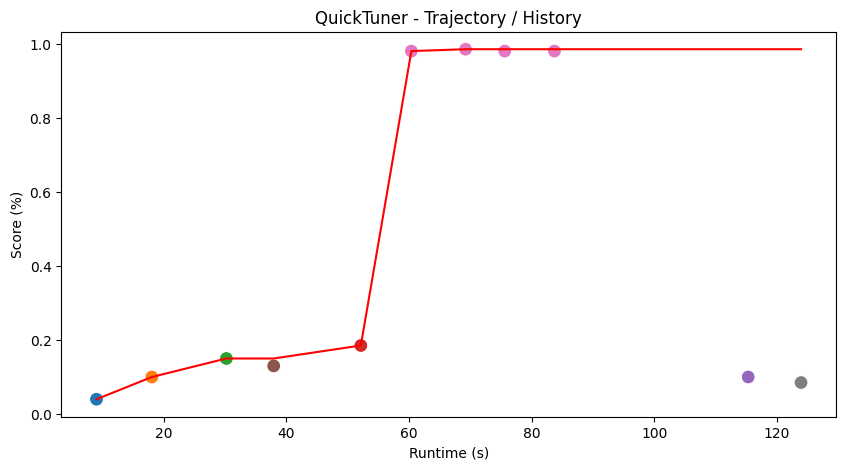

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ids = [c["config_id"] for c in history]
scores = [c["score"] for c in history]

df_traj = pd.DataFrame({"score": traj, "runtime": runtime})
df_hist = pd.DataFrame({"id": ids, "score": scores, "runtime": runtime})
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_hist, x="runtime", y="score", hue="id", palette="tab10", s=100)
sns.lineplot(data=df_traj, x="runtime", y="score", color="red", label="Incumbent")
plt.title("QuickTuner - Trajectory / History")
plt.xlabel("Runtime (s)")
plt.ylabel("Score (%)")
plt.legend([], [], frameon=False)
plt.show()

In [ ]:
print("*****   QUICKTUNE RESULTS   *****")
print("=================================")
print()
print("Best configuration found:")
print(f"Archtitecture: {config['model']}")
print(f"Score: {score*100}")
print(f"Number of epochs trained: {budget}")
print(f"Cost per epoch: {cost}")
print(f"Config: {' '.join([f'{k}={v}' for k, v in config.items()])}")
print()
print("---------------------------------")
print()
print(f"Total number of evaluated configs: {len(tuner.optimizer.evaled)}")
print(f"Total number of evaluations: {len(traj)}")

*****   QUICKTUNE RESULTS   *****

Best configuration found:
Archtitecture: edgenext_x_small
Score: 98.5
Number of epochs trained: 2
Cost per epoch: 7.860462665557861
Config: amp=False batch_size=64 bss_reg=0.0001 clip_grad=10 cotuning_reg=0.0 cutmix=4.0 data_augmentation=random_augment delta_reg=0.0001 drop=0.4 layer_decay=0.75 linear_probing=True lr=0.01 mixup=1.0 mixup_prob=0.25 model=edgenext_x_small opt=adamp pct_to_freeze=1.0 sched=step smoothing=0.1 sp_reg=0.01 stoch_norm=True warmup_epochs=0 warmup_lr=1e-05 weight_decay=0.01 decay_epochs=20 decay_rate=0.5 opt_betas=(0.0, 0.99) ra_magnitude=9 ra_num_ops=2

---------------------------------

Total number of evaluated configs: 8
Total number of evaluations: 11


# Evaluate best model on the Test-Set


First, the model must be exported. During training, the model was slightly modified to implement fine-tuning strategies, which now need to be removed. Typically, the models can be found in the experiment directory `qtt/<timestamp>` by default.

In [ ]:
from qtt.finetune.cv.classification import load_best_model

model = load_best_model(info["path"])

Load some images and predict the class

In [ ]:
model.eval()
model.to("cuda")

transform = tf.Compose(
    [
        tf.Resize(256),
        tf.CenterCrop(224),
        tf.ToTensor(),
        tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
data_path = "dataset/test"
dataset = datasets.ImageFolder(data_path)

images = []
labels = []
for i in np.random.choice(len(dataset), size=10):
    img, label = dataset[i]
    images.append(img)
    labels.append(label)

input = torch.stack([transform(img) for img in images])
input = input.cuda()
with torch.no_grad():
    output = model(input)
    output = output.softmax(-1)
    _, indices = output.topk(1)

indices = indices.cpu().numpy().squeeze()

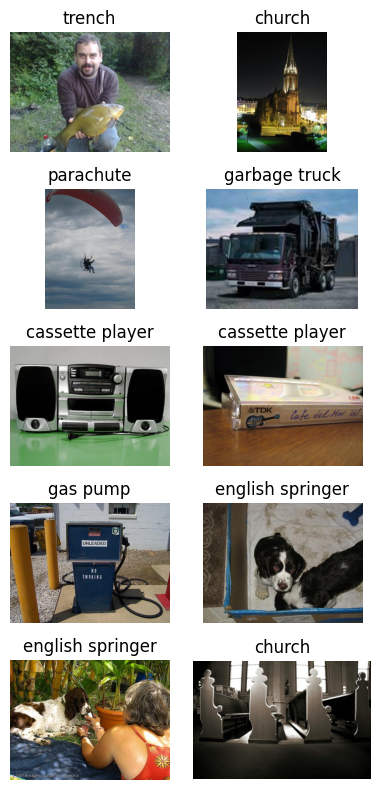

In [ ]:
import matplotlib.pyplot as plt

classes = [
    "trench",
    "english springer",
    "cassette player",
    "chain saw",
    "church",
    "french horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute",
]


# Define a function to display a list of PIL images
def display_images(images, nrows=5, titles=None):
    n_images = len(images)
    if titles is None:
        titles = [""] * n_images
    fig = plt.figure(figsize=(4, 8))

    for n, (image, title) in enumerate(zip(images, titles)):
        ax = fig.add_subplot(nrows, int(n_images / nrows), n + 1)
        ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


titles = [classes[i] for i in indices]
display_images(images, titles=titles)

# Command Line Interface

Additionally, we provide CLI tools for quick testing.

By calling `train path/to/dataset --model <your_favorite_model> --num-classes XY --epochs XYZ ...`

In [ ]:
!train dataset --model xcit_tiny_12_p8_384_dist --pretrained --num-classes 10 --linear-probing --epochs 10 --experiment cli-test --output .
!validate dataset --split test --model xcit_tiny_12_p8_384_dist --num-classes 10 --checkpoint cli-test/model_best.pth.tar

# Test on Flowers102 Dataset 💐

The following script downloads the dataset and extracts the images into the training, validation, and test sets.

In [ ]:
!wget https://gist.githubusercontent.com/rapanti/a2790d3b1af5427f1adef81eabf5e521/raw/f9f0bbfde1c7b9db70329d2123a44833d0ecffb2/dl_extract_flowers102.sh
!bash dl_extract_flowers102.sh

Start finetuning from the command-line. We only train the head of the model.

In [ ]:
!train 102flowers --model xcit_tiny_12_p8_384_dist --pretrained --num-classes 102 --linear-probing --epochs 10 --experiment flowers102-test --output .

24.09.03 11:34:05 - qtt.finetune.cv.classification.train: [INFO] Training with a single process on 1 device (cuda).
24.09.03 11:34:05 - qtt.finetune.cv.classification.train: [INFO] aa: null amp: false amp_dtype: float16 amp_impl: native aug_repeats: 0 aug_splits: 0 auto_augment: null batch_size: 128 bce_loss: false bce_pos_weight: null bce_sum: false bce_target_thresh: null bn_eps: null bn_momentum: null bss_reg: 0.0 channels_last: false checkpoint_hist: 3 class_map: '' clip_grad: null clip_mode: norm color_jitter: 0.4 color_jitter_prob: null cooldown_epochs: 0 cotuning_reg: 0.0 crop_pct: null cutmix: 0.0 cutmix_minmax: null data: projects/datasets/102flowers data_dir: null dataset: '' dataset_download: false decay_epochs: 0 decay_milestones: - 90 - 180 - 270 decay_rate: 0.1 delta_reg: 0.0 device: cuda device_modules: null dist_bn: reduce drop: 0.0 drop_block: null drop_connect: null drop_path: null epoch_repeats: 0.0 epochs: 10 eval_metric: top1 experiment: jupytertest fast_norm: fals

Now evaluate on the test set.

In [ ]:
!validate 102flowers --split test --model xcit_tiny_12_p8_384_dist --num-classes 102 --checkpoint flowers102-test/model_best.pth.tar

24.09.03 11:47:26 - validate: [INFO] Validating in float32. AMP not enabled.
Validating in float32. AMP not enabled.
/home/evilknivl/miniconda3/envs/qtt/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xcit_tiny_12_p8_384_dist to current xcit_tiny_12_p8_384.fb_dist_in1k.
  model = create_fn(
24.09.03 11:47:26 - timm.models._helpers: [INFO] Loaded state_dict from checkpoint 'projects/jupytertest/model_best.pth.tar'
Loaded state_dict from checkpoint 'projects/jupytertest/model_best.pth.tar'
24.09.03 11:47:26 - validate: [INFO] Model xcit_tiny_12_p8_384_dist created, param count: 6533190
Model xcit_tiny_12_p8_384_dist created, param count: 6533190
24.09.03 11:47:26 - timm.data.config: [INFO] Data processing configuration for current model + dataset:
Data processing configuration for current model + dataset:
24.09.03 11:47:26 - timm.data.config: [INFO] 	input_size: (3, 384, 384)
	input_size: (3, 384, 384)
24.09.03 11:47:26 - timm.data.con